In [1]:
import tensorflow_hub as hub
from os import listdir
from os.path import isfile, join
import tarfile
import os
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
# extracting files
files = tarfile.open("/content/drive/MyDrive/DATASETS/ML/P6/images.tar")
files.extractall()

In [3]:
# setting folder for loading images for models
dir = "/content/Images"

In [4]:
# Setting image resolution for MobilNet
IMAGE_RES = 224
# Setting batch size
BATCH_SIZE = 32

In [5]:
# Spliting training set
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES ,IMAGE_RES),
    shuffle=True,
    seed=78,
    validation_split=0.33,
    subset="training",
    interpolation="bilinear",
    follow_links=False
)

Found 20580 files belonging to 120 classes.
Using 13789 files for training.


In [6]:
# spliting validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES ,IMAGE_RES),
    shuffle=True,
    seed=78,
    validation_split=0.33,
    subset="validation",
    interpolation="bilinear",
    follow_links=False
)

Found 20580 files belonging to 120 classes.
Using 6791 files for validation.


In [7]:
# Computing number of classes
num_classes = len(training_set.class_names)

# Computing number of batch
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Batchs: {}'.format(num_training_examples))
print('Total Number of Validation Batchs: {} \n'.format(num_validation_examples))

Total Number of Classes: 120
Total Number of Training Batchs: 431
Total Number of Validation Batchs: 213 



In [8]:
# rescaling images
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).prefetch(1)

validation_batches = validation_set.map(format_image).prefetch(1)

In [9]:
# creating image generator for train split
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.33)

# creating image generator for validation split
image_gen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.33)

# creating train validation split
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='binary',
                                                     subset='training')

validation_generator = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='binary',
                                                     subset='validation')

Found 13846 images belonging to 120 classes.
Found 6734 images belonging to 120 classes.


In [10]:
# Loading model from tensorflow hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

# Setting pretrained model to no trainable
feature_extractor.trainable = False

In [11]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.6MB/s 


In [12]:
import kerastuner as kt

In [13]:
def model_builder(hp):
  model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation = "softmax")
])

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [14]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
tuner.search(train_data_gen, epochs=50, validation_data = validation_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 3 Complete [00h 07m 42s]
val_accuracy: 0.6231065988540649

Best val_accuracy So Far: 0.7797743082046509
Total elapsed time: 00h 23m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [17]:
print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=best_hps.get)

# creating model
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation = "softmax")
])
# compile model
model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
# Create a callback that saves the model's weights
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
# Create a callback that stops fitting when val loss do not decrease
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [24]:
EPOCHS = 50

# fitting model
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[callback,cp_callback])

Epoch 1/50
433/433 [==============================] - 231s 531ms/step - loss: 2.9462 - accuracy: 0.3393 - val_loss: 0.8298 - val_accuracy: 0.7516

Epoch 00001: val_loss improved from inf to 0.82984, saving model to training_3/cp.ckpt
Epoch 2/50
433/433 [==============================] - 229s 530ms/step - loss: 1.3068 - accuracy: 0.6307 - val_loss: 0.7240 - val_accuracy: 0.7778

Epoch 00002: val_loss improved from 0.82984 to 0.72405, saving model to training_3/cp.ckpt
Epoch 3/50
433/433 [==============================] - 229s 529ms/step - loss: 1.1362 - accuracy: 0.6765 - val_loss: 0.6657 - val_accuracy: 0.7925

Epoch 00003: val_loss improved from 0.72405 to 0.66570, saving model to training_3/cp.ckpt
Epoch 4/50
433/433 [==============================] - 229s 529ms/step - loss: 1.0749 - accuracy: 0.6870 - val_loss: 0.6579 - val_accuracy: 0.7900

Epoch 00004: val_loss improved from 0.66570 to 0.65785, saving model to training_3/cp.ckpt
Epoch 5/50
433/433 [==============================] 

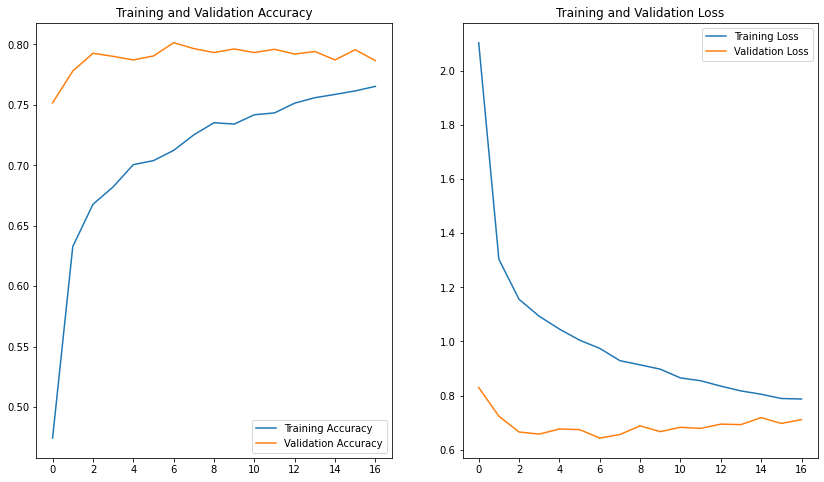

In [25]:
# Plotting accuracy and val loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_path)

In [27]:
# model scoring
model.evaluate(validation_generator)

211/211 [==============================] - 29s 135ms/step - loss: 0.6434 - accuracy: 0.8013


[0.6433853507041931, 0.8013067841529846]

# Predict

In [28]:
class_names = training_set.class_names

# Cleaning class names 
class_names_clean = []
for c in class_names:  
  first, second = c.split("-", maxsplit =1)
  class_names_clean.append(second)

type(class_names_clean)
type(np.asarray(class_names_clean))

class_names_clean = np.asarray(class_names_clean)

In [29]:
# separate images and label
image_batch, label_batch = next(iter(validation_batches))

In [30]:
# make a prediction 
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names_clean[predicted_ids]
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            tf.Tensor(
[ 48  60 102   2  21  95  15  11  82  26  27  48  64  44  79  91  96  41
 104  23  62  91   5  66  97  43  91  45  78  56  59  16], shape=(32,), dtype=int32)
Predicted labels:  [ 48  60 102   2  21  95  15  11  82  26  27  48  61  44  79  91  96  34
 104  84  62  91   5  66  99  43  91  45  78  56  59  11]


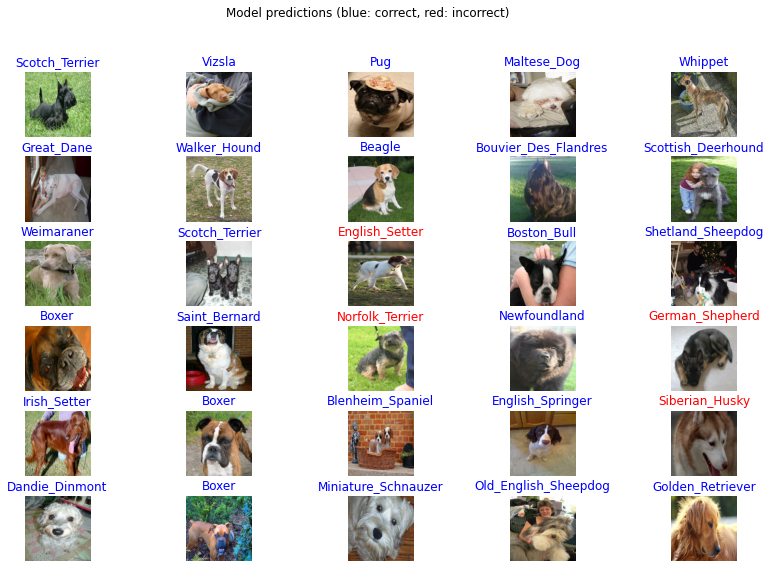

In [31]:
# plotting predicted images
plt.figure(figsize=(14,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Export

In [32]:
import time

t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1614333134.h5


In [33]:
np.save("/content/drive/MyDrive/app/class_names_clean",class_names_clean)

In [34]:
export_path_keras

'./1614333134.h5'

# API

https://dogs-prediction.herokuapp.com/
